In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU. Using CPU.")

GPU is available!
Using device: Tesla T4


In [3]:
!pip install gdown --quiet
!gdown '1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw'

Downloading...
From (original): https://drive.google.com/uc?id=1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw
From (redirected): https://drive.google.com/uc?id=1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw&confirm=t&uuid=10f80674-0787-4b47-b45b-3f8cb8268395
To: /content/final_data_with_summarization.csv
100% 288M/288M [00:01<00:00, 225MB/s]


# 1. Loading the Data

In [4]:
df = pd.read_csv(r"final_data_with_summarization.csv")

In [5]:
df["input"] = df["text_summary"].fillna(df["text"])

In [6]:
df["input"].isnull().sum()

np.int64(39)

In [7]:
X = df["title"].fillna("") + " " + df["input"].fillna("")

In [8]:
# now fake = 1
df["label"] = df["label"].map({0: 1, 1: 0})

In [9]:
Y = df["label"]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [11]:
X_train.shape, X_val.shape, X_test.shape

((49043,), (8655,), (14425,))

In [12]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

# 2. Preparing Data Loaders and Model

We use the [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model from huggingface and fine tune it.

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.astype("float32")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [15]:
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

In [16]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

In [18]:
class EmbeddingClassifier(nn.Module):
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        super(EmbeddingClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.classifier = nn.Sequential(
            nn.Linear(384, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2)
        )

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    def forward(self, input_texts):
        encoded = self.tokenizer(
            input_texts,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(next(self.parameters()).device)

        model_output = self.encoder(**encoded)
        sentence_embeddings = self.mean_pooling(model_output, encoded['attention_mask'])
        logits = self.classifier(sentence_embeddings)
        return logits  # ouput shape: [batchsize, 2]

In [19]:
for features, labels in train_loader:
  break

In [20]:
NN_Model = EmbeddingClassifier()
NN_Model.to(device)

EmbeddingClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elem

As we can see, we appended a multi-layered perceptron on top of the embedding model. Lets see if we get expected output in a forward pass for a batch of data.

In [21]:
outputs = NN_Model(features)

In [22]:
outputs.shape

torch.Size([64, 2])

In [23]:
all_on_gpu = all(p.device.type == 'cuda' for p in NN_Model.parameters())
print("All model parameters on GPU:", all_on_gpu)

All model parameters on GPU: True


In [24]:
total_params = sum(p.numel() for p in NN_Model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 22779266


Perfect!!! Our forward pass works as expected. Now, lets create some helper functions and train our model.

# 3. Helper Functions

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def perform_deep_test_analysis(y_test, test_preds: np.array, test_preds_proba: np.array, model_name: str) -> None:
    """"
    This function takes in a model object and model name, and performs a deep analysis on the model's performance on the test set.
    It prints classification report, confusion matrix, ROC AUC score and plots the ROC curve.
    """
    cm = confusion_matrix(y_test, test_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")
    print("FOR TESTING SET: ")
    print(classification_report(y_test, test_preds))
    print("\n")

    print(f"ROC AUC Score: {roc_auc_score(y_test, test_preds_proba):.2%}")
    print("\n")

    fpr, tpr, _ = roc_curve(y_test, test_preds_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# 4. Model Training

In [27]:
import torch.optim as optim

scaler = torch.cuda.amp.GradScaler()

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN_Model.parameters(), lr=0.0001, weight_decay=0.001)
num_epochs = 7
early_stopping_patience = 4

In [29]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_loss = np.inf
epochs_no_improve = 0
best_model_wts = NN_Model.state_dict()

for epoch in range(num_epochs):
    NN_Model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    for xb, yb in tqdm(train_loader):
        yb = yb.to(device).long() # features are already moved to GPU inside the model class
        optimizer.zero_grad()

        # pytorch's default mixed precision training for speed-up
        with torch.cuda.amp.autocast():
          out = NN_Model(xb)
          loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(xb)
        preds = out.argmax(dim=1)
        running_corrects += (preds == yb).sum().item()
        running_total += yb.size(0)

    epoch_train_loss = running_loss / running_total
    epoch_train_acc = running_corrects / running_total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    NN_Model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_total = 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader):
            yb = yb.to(device).long()

            # pytorch's default mixed precision training for speed-up
            with torch.cuda.amp.autocast():
              out = NN_Model(xb)
              loss = criterion(out, yb)

            val_running_loss += loss.item() * len(xb)
            preds = out.argmax(dim=1)
            val_running_corrects += (preds == yb).sum().item()
            val_running_total += yb.size(0)

    epoch_val_loss = val_running_loss / val_running_total
    epoch_val_acc = val_running_corrects / val_running_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.4f}, "
          f"Val Loss={epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.4f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        best_model_wts = NN_Model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

100%|██████████| 136/136 [00:21<00:00,  6.34it/s]


Epoch 1: Train Loss=0.1775, Train Acc=0.9295, Val Loss=0.1246, Val Acc=0.9467


100%|██████████| 136/136 [00:21<00:00,  6.31it/s]


Epoch 2: Train Loss=0.0902, Train Acc=0.9672, Val Loss=0.2090, Val Acc=0.9233


100%|██████████| 136/136 [00:20<00:00,  6.52it/s]


Epoch 3: Train Loss=0.0777, Train Acc=0.9730, Val Loss=0.1753, Val Acc=0.9523


100%|██████████| 136/136 [00:21<00:00,  6.30it/s]

Epoch 4: Train Loss=0.0556, Train Acc=0.9817, Val Loss=0.1409, Val Acc=0.9570
Early stopping at epoch 4


In [30]:
torch.save(best_model_wts, 'EmbeddingClassifier_FineTuned.pth')

In [31]:
NN_Model.load_state_dict(torch.load('EmbeddingClassifier_FineTuned.pth'))

<All keys matched successfully>

In [34]:
def make_predictions_using_NN(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for xb, labels in tqdm(data_loader):
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    return all_preds, all_probs

In [35]:
train_preds, train_probs_1dCNN = make_predictions_using_NN(NN_Model, train_loader)
val_preds, val_probs_1dCNN = make_predictions_using_NN(NN_Model, val_loader)
test_preds, test_probs_1dCNN = make_predictions_using_NN(NN_Model, test_loader)

100%|██████████| 226/226 [01:27<00:00,  2.59it/s]


In [36]:
print("Training performance")
print(classification_report(y_train, train_preds))

Training performance for 1-d CNN
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     25190
           1       0.98      1.00      0.99     23853

    accuracy                           0.99     49043
   macro avg       0.99      0.99      0.99     49043
weighted avg       0.99      0.99      0.99     49043



In [37]:
print("Val performance")
print(classification_report(y_val, val_preds))

Val performance for 1-d CNN
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4558
           1       0.94      0.98      0.96      4097

    accuracy                           0.96      8655
   macro avg       0.96      0.96      0.96      8655
weighted avg       0.96      0.96      0.96      8655



In [38]:
print("Test performance")
print(classification_report(y_test, test_preds))

Test performance for 1-d CNN
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      7347
           1       0.94      0.98      0.96      7078

    accuracy                           0.96     14425
   macro avg       0.96      0.96      0.96     14425
weighted avg       0.96      0.96      0.96     14425



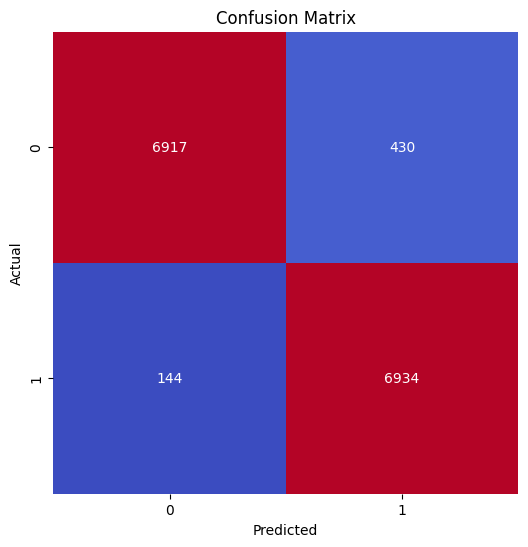



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      7347
           1       0.94      0.98      0.96      7078

    accuracy                           0.96     14425
   macro avg       0.96      0.96      0.96     14425
weighted avg       0.96      0.96      0.96     14425



ROC AUC Score: 99.48%




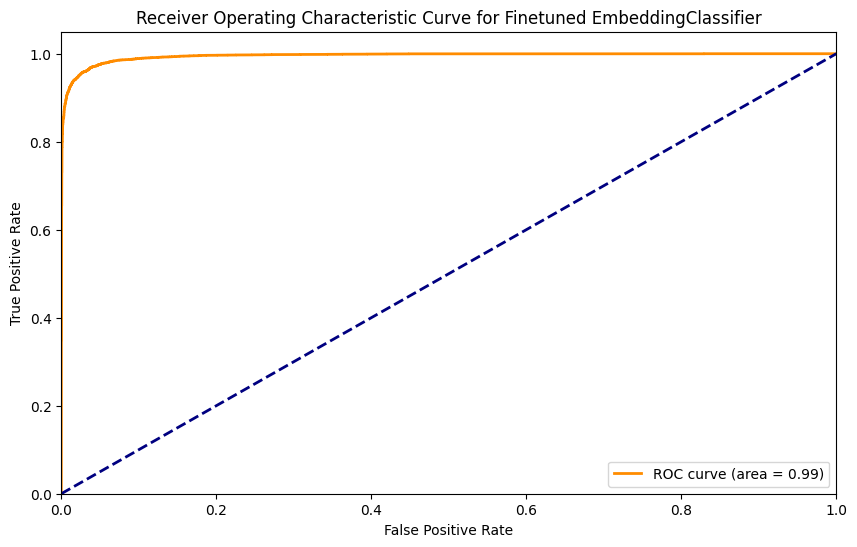

In [40]:
perform_deep_test_analysis(y_test, test_preds, test_probs_1dCNN[:, 1], "Finetuned EmbeddingClassifier")